<a href="https://colab.research.google.com/github/Leonas2000/Lil-Beethoven/blob/main/Lil'_Beethoven.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Imports

import numpy as np
import sys
import os
from scipy.io import wavfile
!pip install python_speech_features
from python_speech_features import mfcc

import librosa
import matplotlib.pyplot as plt
from scipy.io import wavfile,savemat

import os.path

# Import keras main libraries
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation
from keras.regularizers import l2
from keras import callbacks
from keras.callbacks import History, ModelCheckpoint, EarlyStopping




  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=898e5ed72246f19786c63817563e30d98acd5e6577b063fa272457088c6db7cb
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features


In [ ]:
#@title Preprocessing / CreateList

# Read args
Label_text_source = "/content/drive/MyDrive/Lil_Beethoven/Input/Txt/";
Output_dir = "/content/drive/MyDrive/Lil_Beethoven/Output/";

f = open(Output_dir + 'train.lst','w')

for filename in os.listdir(Label_text_source):
    f.write(filename + '\n')

f.close()

:)

Split the train.lst file to train_tr.lst, train_va.lst and test.lst

then run the code for different source_List with the above files path (_tr _va and test)


In [ ]:
#@title Preprocessing / WAV2mat_batch


# Parameters
hop_length_in = 512
n_bins_in = 252
bins_octaves_in = 36
win_step = 0.01
number_notes = 88
num_cep_def = 40
num_filt_def = 40
length_per_file = 4000000

# Read args
source_List = "/content/drive/MyDrive/Lil_Beethoven/Output/test.lst";
source_WAV = "/content/drive/MyDrive/Lil_Beethoven/Input/Wav/";
source_Txt = "/content/drive/MyDrive/Lil_Beethoven/Input/Txt/";
out_mat = "/content/drive/MyDrive/Lil_Beethoven/Output/";

# Output .npz
train2mat = []
labels2mat = []
contador = 0

# Get the name of the list
source_list_split = source_List.split('.')
source_list_split = source_list_split[0].split('/')
list_name = source_list_split[-1]

# Open the list
file_List = open( source_List , "r")

# Iterate on every file
for filename in file_List:

    filename_split = filename.split('.')

    #### MFCC extraction ####
    # Transform to raw data from wav. Get the sampling rate 2
    sampling_freq, stereo_vector = wavfile.read(source_WAV + filename_split[0] + '.wav')
    win_len = 512/float(sampling_freq)
    #plt.imshow( np.array(np.absolute(cqt_feat)))
    #plt.show()
    # Transform to mono
    mono_vector = np.mean(stereo_vector, axis = 1)
    # Extract mfcc_features
    cqt_feat = np.absolute(librosa.cqt(mono_vector, sampling_freq, hop_length=hop_length_in,n_bins=n_bins_in,bins_per_octave=bins_octaves_in)).transpose()
    #### LABELING ####
    # Number of frames in the file
    number_Frames = np.max( cqt_feat.shape[0])
    # Aux_Vector of times
    vector_aux = np.arange(1, number_Frames + 1)*win_len
    # Binary labels - we need multiple labels at the same time to represent the chords
    labels = np.zeros((number_Frames, number_notes))


    # Open the align txt labels
    file = open( source_Txt + filename_split[0] + '.txt' , "r")
    #f = open(out_mat + filename_split[0] + 'label.lst','w')
    # Loop over all the lines 
    for line in file: 
        line_split = line.split()
        if line_split[0] == "OnsetTime":
            print ("Preprocessing operations . . .")
        else:
            # Get the values from the text
            init_range, fin_range, pitch = float(line_split[0]), float(line_split[1]), int(line_split[2])
            # Pitch move to 0-87 range
            pitch = pitch - 21;
            # Get the range indexes
            index_min = np.where(vector_aux >= init_range)
            index_max = np.where(vector_aux - 0.01 > int((fin_range)*100)/float(100))
            labels[index_min[0][0]:index_max[0][0],pitch] = 1
    
    #If you want to save the labels to a txt file 
    """for i in range( number_Frames):
        for j in range( 88 ):
            if labels[i][j] == 1:
                f.write('%f' %vector_aux[i] + ' - ' + '%d\n' %j)
    f.close()
    """
    file.close()
    """
    plt.figure()
    plt.imshow( np.array(labels.transpose()),aspect='auto')
    plt.figure()
    plt.imshow( np.array(np.absolute(cqt_feat)), aspect='auto')
    plt.show()
    """
    while (len(train2mat) + len(cqt_feat)) >= length_per_file:
        size_to_add = length_per_file - len(train2mat)
        # Append to add to npz
        train2mat.extend(cqt_feat[0:size_to_add,:])
        # Append the labels 
        labels2mat.extend(labels[0:size_to_add,:])
        train2mat = np.array(train2mat)
        labels2mat = np.array(labels2mat)
        # Plotting stuff
        print (" Shape of MFCC is " + str(train2mat.shape) + " - Saved in " + out_mat + list_name + '/' + str(contador) + list_name)
        print (" Shape of Labels is " + str(labels2mat.shape)  + " - Saved in " + out_mat + list_name + '/' + str(contador) + list_name)
        np.save('{}_X'.format(out_mat + list_name + '/' + str(contador) + list_name ), train2mat)
        np.save('{}_y'.format(out_mat + list_name + '/' + str(contador) + list_name), labels2mat)
        contador = contador + 1;
        train2mat = []
        labels2mat = []
        cqt_feat = cqt_feat[size_to_add:,:]
        labels = labels[size_to_add:,:]
    if len(cqt_feat) == length_per_file:
        # Append to add to npz
        train2mat.extend(cqt_feat)
        # Append the labels 
        labels2mat.extend(labels)
        train2mat = np.array(train2mat)
        labels2mat = np.array(labels2mat)
        # Plotting stuff
        print (" Shape of MFCC is " + str(train2mat.shape)  + " - Saved in " + out_mat + list_name + '/' + str(contador) + list_name)
        print (" Shape of Labels is " + str(labels2mat.shape)  + " - Saved in " + out_mat + list_name + '/' + str(contador) + list_name)
        np.save('{}_X'.format(out_mat + list_name + '/' + str(contador) + list_name ), train2mat)
        np.save('{}_y'.format(out_mat + list_name + '/' + str(contador) + list_name), labels2mat)
        contador = contador + 1;
        train2mat = []
        labels2mat = []
    elif len(cqt_feat) > 0:
        # Append to add to npz
        train2mat.extend(cqt_feat)
        # Append the labels 
        labels2mat.extend(labels)

train2mat = np.array(train2mat)
labels2mat = np.array(labels2mat)
"""
plt.figure()
plt.imshow( np.array(labels2mat.transpose()),aspect='auto')
plt.colorbar()
plt.figure()
plt.imshow( np.array(train2mat.transpose()), aspect='auto')
plt.colorbar()
plt.show()
"""
# Plotting stuff
print (" Shape of MFCC is " + str(train2mat.shape)  + " - Saved in " + out_mat + list_name + '/' + str(contador) + list_name)
print (" Shape of Labels is " + str(labels2mat.shape)  + " - Saved in " + out_mat + list_name + '/' + str(contador) + list_name)

np.save('{}_X'.format(out_mat + list_name + '/' + str(contador) + list_name ), train2mat)
np.save('{}_y'.format(out_mat + list_name + '/' + str(contador) + list_name), labels2mat)

Preprocessing operations . . .
Preprocessing operations . . .
Preprocessing operations . . .
Preprocessing operations . . .
Preprocessing operations . . .
 Shape of MFCC is (110638, 252) - Saved in /content/drive/MyDrive/Lil_Beethoven/Output/test/0test
 Shape of Labels is (110638, 88) - Saved in /content/drive/MyDrive/Lil_Beethoven/Output/test/0test


In [ ]:
#out_mat = "/content/drive/MyDrive/Lil_Beethoven/Output/";
#np.save('{}_X'.format(out_mat + list_name + '/' + str(contador) + list_name ), train2mat)
#np.save('{}_y'.format(out_mat + list_name + '/' + str(contador) + list_name), labels2mat)

In [ ]:
#@title Preprocessing / mat2norm_batch

# Read args
source = "/content/drive/MyDrive/Lil_Beethoven/Output/"
train_folder = "train_tr/"
val_folder = "train_va/"
test_folder = "test/"

mean_X = []
min_X = []
max_X = []

print ("Get max - min ")
# Iterate on every file
for filename in os.listdir(source + train_folder):
    if "tr_X" in filename:
        X_train = np.load(source + train_folder + filename)
        max_X.append(X_train.max())
        min_X.append(X_train.min())
        
max_train = max(max_X)
min_train = min(min_X)

print ("Get mean")
total_length = 0
# Iterate on every file
for filename in os.listdir(source + train_folder):
    if "tr_X" in filename:
        X_train = np.load(source + train_folder + filename)
        X_train_norm = (X_train - min_train)/(max_train - min_train)
        # Compute the mean
        mean_X.append(np.sum(X_train_norm, axis = 0))
        total_length = total_length + len(X_train_norm)

train_mean = np.sum(mean_X, axis = 0)/float(total_length)

print ("Normalize ")
# Iterate on every file
for filename in os.listdir(source + train_folder):
    filename_split = filename.split('.')
    if "tr_X" in filename:
        X_train = np.load(source + train_folder + filename)
        X_train_norm = (X_train - min_train)/(max_train - min_train) 
        X_train_norm = X_train_norm - train_mean
        print ("X_train file : " + filename)
        np.save('{}'.format(source + train_folder + filename_split[0] ), X_train_norm)

for filename in os.listdir(source + val_folder):
    filename_split = filename.split('.')
    if "va_X" in filename:
        X_val = np.load(source + val_folder+ filename)
        X_val_norm = (X_val - min_train)/(max_train - min_train)
        X_val_norm = X_val_norm - train_mean
        print ("X_val file : " + filename)
        np.save('{}'.format(source + val_folder + filename_split[0]), X_val_norm)
    
for filename in os.listdir(source + test_folder):
    filename_split = filename.split('.')
    if "_X" in filename: 
        X_test = np.load(source + test_folder + filename)  
        X_test_norm = (X_test - min_train)/(max_train - min_train) 
        X_test_norm = X_test_norm - train_mean
        print ("X_test file : " + filename)
        np.save('{}'.format(source + test_folder + filename_split[0] ), X_test_norm) 
    

print (train_mean)
print (min_train)
print (max_train)

Get max - min 
Get mean
Normalize 
X_train file : 0train_tr_X.npy
X_val file : 0train_va_X.npy
X_test file : 0test_X.npy
[0.02915712 0.02915712 0.02915712 0.02915712 0.02915712 0.02915712
 0.02915712 0.02915712 0.02915712 0.02915712 0.02915712 0.02915712
 0.02915712 0.02915712 0.02915712 0.02915712 0.02915712 0.02915712
 0.02915712 0.02915712 0.02915712 0.02915712 0.02915712 0.02915712
 0.02915712 0.02915712 0.02915712 0.02915712 0.02915712 0.02915712
 0.02915712 0.02915712 0.02915712 0.02915712 0.02915712 0.02915712
 0.02915712 0.02915712 0.02915712 0.02915712 0.02915712 0.02915712
 0.02915712 0.02915712 0.02915712 0.02915712 0.02915712 0.02915712
 0.02915712 0.02915712 0.02915712 0.02915712 0.02915712 0.02915712
 0.02915712 0.02915712 0.02915712 0.02915712 0.02915712 0.02915712
 0.02915712 0.02915712 0.02915712 0.02915712 0.02915712 0.02915712
 0.02915712 0.02915712 0.02915712 0.02915712 0.02915712 0.02915712
 0.02915712 0.02915712 0.02915712 0.02915712 0.02915712 0.02915712
 0.02915

In [ ]:
!cp /content/drive/MyDrive/Lil_Beethoven/Output/test/*.npy /content/drive/MyDrive/Lil_Beethoven/Output2/
!cp /content/drive/MyDrive/Lil_Beethoven/Output/train_tr/*.npy /content/drive/MyDrive/Lil_Beethoven/Output2/
!cp /content/drive/MyDrive/Lil_Beethoven/Output/train_va/*.npy /content/drive/MyDrive/Lil_Beethoven/Output2/


In [ ]:
#@title Preprocessing / minidataset


# Read args
source = "/content/drive/MyDrive/Lil_Beethoven/Output2/";

# Iterate on every file
for filename in os.listdir(source):
    if "tr_X" in filename:
        X_train = np.load(source + filename)
        print ("X_train file : " + filename)
    elif "va_X" in filename:
        X_val = np.load(source + filename)
        print ("X_val file : " + filename)
    elif "_X" in filename: 
        X_test = np.load(source + filename)
        print ("X_test file : " + filename)
    elif "tr_y" in filename:
        y_tr = np.load(source + filename)
        print ("X_val file : " + filename)
    elif "va_y" in filename: 
        y_va = np.load(source + filename)
        print ("X_test file : " + filename)

X_train = X_train[1:5000,:]
X_val = X_val[1:5000,:]
y_tr = y_tr[1:5000,:]
y_va = y_va[1:5000,:]

# Normalization 
max_train = X_train.max()
min_train = X_train.min()
max_val = X_val.max()
min_val = X_val.min()
max_test = X_test.max()
min_test = X_test.min()

"""max_Global = max(max_train, max_val, max_test)
min_Global = min(min_train, min_val, min_test)
X_val_norm = (X_val - min_Global)/(max_Global - min_Global)
X_test_norm = (X_test - min_Global)/(max_Global - min_Global)
X_train_norm = (X_train - min_Global)/(max_Global - min_Global)"""

X_val_norm = (X_val - min_train)/(max_train - min_train)
X_test_norm = (X_test - min_train)/(max_train - min_train)
X_train_norm = (X_train - min_train)/(max_train - min_train)

# Compute the mean
train_mean = np.mean(X_train_norm, axis = 0)

# Substract it
X_train_norm = X_train_norm - train_mean
X_val_norm = X_val_norm - train_mean
X_test_norm = X_test_norm - train_mean

# Get the name
np.save('{}X_train_norm'.format(source + 'normalized/' ), X_train_norm)
np.save('{}X_val_norm'.format(source + 'normalized/' ), X_val_norm)
np.save('{}y_train_norm'.format(source + 'normalized/' ), y_tr)
np.save('{}y_val_norm'.format(source + 'normalized/' ), y_va)

X_test file : 0test_X.npy
X_train file : 0train_tr_X.npy
X_val file : 0train_tr_y.npy
X_val file : 0train_va_X.npy
X_test file : 0train_va_y.npy


In [ ]:
#@title Train 1

''###### TRAIN 1: DNN - 3 layers - 150 unis per layer ######'''

# We need to set the random seed so that we get ther same results with the same parameters
np.random.seed(400)  

mini_batch_size, num_epochs = 100, 100
input_size = 252
number_units = 256
number_layers = 3
number_classes = 88
best_accuracy = 0
contador_bad = 0

#Arg inputs
data_directory = "/content/drive/MyDrive/Lil_Beethoven/Output/"
weights_dir = "/content/drive/MyDrive/Lil_Beethoven/Saved_weights/"

print ('Build model...') 
model = Sequential()
history = History()

print ('Load validation data...')
X_val = np.load(data_directory + "train_va/" + str(0) + "train_va_X.npy" )
y_val = np.load(data_directory + "train_va/" + str(0) + "train_va_y.npy" )

# Count the number of files in the training folder 
num_tr_batches = len([name for name in os.listdir(data_directory + "train_tr/")])/2
num_tr_batches = int(num_tr_batches)
print ('Loading all data')
for i in range(num_tr_batches):
    print ("Batching..." + str(i) + "train_tr_X.npy")
    X_train = np.array(np.load(data_directory + "train_tr/" + str(i) + "train_tr_X.npy" ))
    y_train = np.array(np.load(data_directory + "train_tr/" + str(i) + "train_tr_y.npy" ))
    if i == 0:
        X = X_train
        y = y_train
    else:
        X = np.concatenate((X,X_train), axis = 0)
        y = np.concatenate((y,y_train), axis = 0)

print (X.shape)
print ("Adding 1st layer of {} units".format(number_units) )
model.add(Dense(number_units, input_shape=(input_size,), kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
for i in range(number_layers-1):
    print ("Adding %d" % (i+2) + "th layer of %d" % number_units + " units")
    model.add(Dense(number_units, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))

print (" Adding classification layer")
model.add(Dense(number_classes, kernel_initializer='normal', activation='sigmoid'))

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

checkpointer = ModelCheckpoint(filepath= weights_dir + "weights.hdf5", verbose=1, save_best_only=False)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')

training_log = open(weights_dir + "Training.log", "w")
print ('Train . . .')
# let's say you have an ImageNet generat        print "Fitting the batch :"
save = model.fit(X, y,batch_size=mini_batch_size,epochs = num_epochs,validation_data=(X_val, y_val),verbose=1,callbacks=[checkpointer,early])
training_log.write(str(save.history) + "\n")
training_log.close()

Build model...
Load validation data...
Loading all data
Batching...0train_tr_X.npy
(335742, 252)
Adding 1st layer of 256 units
Adding 2th layer of 256 units
Adding 3th layer of 256 units
 Adding classification layer
Train . . .
Epoch 1/100
3357/3358 [============================>.] - ETA: 0s - loss: 0.0271 - mean_squared_error: 0.0271
Epoch 00001: saving model to /content/drive/MyDrive/Lil_Beethoven/Saved_weights/weights.hdf5
3358/3358 [==============================] - 19s 5ms/step - loss: 0.0271 - mean_squared_error: 0.0271 - val_loss: 0.0304 - val_mean_squared_error: 0.0304
Epoch 2/100
3351/3358 [============================>.] - ETA: 0s - loss: 0.0164 - mean_squared_error: 0.0164
Epoch 00002: saving model to /content/drive/MyDrive/Lil_Beethoven/Saved_weights/weights.hdf5
3358/3358 [==============================] - 21s 6ms/step - loss: 0.0164 - mean_squared_error: 0.0164 - val_loss: 0.0279 - val_mean_squared_error: 0.0279
Epoch 3/100
3355/3358 [============================>.] - ETA

In [ ]:
#@title train load (don't need now)
'''###### TRAIN 1: DNN - 3 layers - 150 unis per layer ######'''


# We need to set the random seed so that we get ther same results with the same parameters
np.random.seed(400)  


mini_batch_size, num_epochs = 100, 100
input_size = 40
number_units = 256
number_layers = 3
number_classes = 88
best_accuracy = 0

#Arg inputs
data_directory = "/content/drive/MyDrive/Lil_Beethoven/Output/"
weights_dir = "/content/drive/MyDrive/Lil_Beethoven/Saved_weights/"

print ('Load model...' )
model = load_model(weights_dir + "weights.hdf5")
starting_epoch = 13

print ('Load validation data...')
X_val = np.load(data_directory + "train_va/" + str(0) + "train_va_X.npy" )
y_val = np.load(data_directory + "train_va/" + str(0) + "train_va_y.npy" )

# Count the number of files in the training folder 
num_tr_batches = len([name for name in os.listdir(data_directory + "train_tr/")])/2

# Count the number of files in the training folder 
num_tr_batches = len([name for name in os.listdir(data_directory + "train_tr/")])/2
num_tr_batches = int(num_tr_batches)

print ('Loading all data')
for i in range(num_tr_batches):
    print ("Batching..." + str(i) + "train_tr_X.npy")
    X_train = np.array(np.load(data_directory + "train_tr/" + str(i) + "train_tr_X.npy" ))
    y_train = np.array(np.load(data_directory + "train_tr/" + str(i) + "train_tr_y.npy" ))
    if i == 0:
        X = X_train
        y = y_train
    else:
        X = np.concatenate((X,X_train), axis = 0)
        y = np.concatenate((y,y_train), axis = 0)
        
checkpointer = ModelCheckpoint(filepath= weights_dir + "weights.hdf5", verbose=1, save_best_only=False)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')

training_log = open(weights_dir + "Training.log", "w")
print ('Train . . .')
# let's say you have an ImageNet generat        print "Fitting the batch :"
save = model.fit(X, y,batch_size=mini_batch_size,epochs = num_epochs,validation_data=(X_val, y_val),verbose=1,callbacks=[checkpointer,early])
training_log.write(str(save.history) + "\n")
training_log.close()

Load model...
Load validation data...
Loading all data
Batching...0train_tr_X.npy
Train . . .
Epoch 1/100
3352/3358 [============================>.] - ETA: 0s - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 00001: saving model to /content/drive/MyDrive/Lil_Beethoven/Saved_weights/weights.hdf5
3358/3358 [==============================] - 17s 5ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0492 - val_mean_squared_error: 0.0492
Epoch 2/100
3349/3358 [============================>.] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 00002: saving model to /content/drive/MyDrive/Lil_Beethoven/Saved_weights/weights.hdf5
3358/3358 [==============================] - 16s 5ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0496 - val_mean_squared_error: 0.0496
Epoch 3/100
3351/3358 [============================>.] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 00003: saving model to /content/drive/MyDrive/Lil_Beethoven/Saved_weights/weigh

In [ ]:
#@title Text 2 text
'''###### TRAIN 1: DNN - 3 layers - 150 unis per layer ######'''

# We need to set the random seed so that we get ther same results with the same parameters
np.random.seed(400)  



mini_batch_size, num_epochs = 100, 50
input_size = 252
number_units = 256
number_layers = 3
number_classes = 88
size_samples = 100
data_directory = "/content/drive/MyDrive/Lil_Beethoven/Output/test/"
weights_dir = "/content/drive/MyDrive/Lil_Beethoven/Saved_weights/"

X = []
y = []

num_test_batches = len([name for name in os.listdir(data_directory )])/2
num_test_batches = int(num_test_batches)
print ('Loading test data')
for i in range(num_test_batches):
    print ("Batching..." + str(i) + "test_X.npy")
    X_test = np.array(np.load(data_directory + str(i) + "test_X.npy" ))
    y_test = np.array(np.load(data_directory + str(i) + "test_y.npy" ))
    if i == 0:
        X = X_test
        y = y_test
    else:
        X = np.concatenate((X,X_test), axis = 0)
        y = np.concatenate((y,y_test), axis = 0)

# Load the model 
model = load_model(weights_dir + "weights.hdf5")
TP = 0
FP = 0
FN = 0

print ("Predicting model. . . ")
predictions = model.predict(X, batch_size=mini_batch_size, verbose = 1) 
predictions = np.array(predictions).round()
predictions[predictions > 1] = 1
np.save('{}predictions'.format(weights_dir), predictions)
print ("\nCalculating accuracy. . .")
TP = np.count_nonzero(np.logical_and( predictions == 1, y == 1 ))
FN = np.count_nonzero(np.logical_and( predictions == 0, y == 1 ))
FP = np.count_nonzero(np.logical_and( predictions == 1, y == 0 ))
print("TP:" + str(TP), "FP:" + str(FP), "FN:" + str(FN))
if (TP + FN) > 0 and (TP +FP) > 0:
    R = TP/float(TP + FN)
    P = TP/float(TP + FP)
    A = 100*TP/float(TP + FP + FN)
    if P == 0 and R == 0:
      F = 0
    else: 
      F = 100*2*P*R/(P + R)
else: 
    A = 0
    F = 0
    R = 0
    P = 0

print ('\n F-measure pre-processed: ')
print (F)
print ('\n Accuracy pre-processed: ')
print (A)

print ("\nCleaning model . . .")
for a in range(predictions.shape[1]):
    for j in range(2,predictions.shape[0]-3):
        if predictions[j-1,a] == 1 and predictions[j,a] == 0 and predictions[j+1,a] == 0 and predictions[j+2,a] == 1:
            predictions[j,a] = 1
            predictions[j+1,a] = 1
        if predictions[j-2,a] == 0 and predictions[j-1,a] == 0 and predictions[j,a] == 1 and predictions[j+1,a] == 1 and predictions[j+2,a] == 0 and predictions[j+3,a] == 0:
            predictions[j,a] = 0
            predictions[j+1,a] = 0
        if predictions[j-1,a] == 0 and predictions[j,a] == 1 and predictions[j+1,a] == 0 and predictions[j+2,a] == 0:
            predictions[j,a] = 0
        if predictions[j-1,a] == 1 and predictions[j,a] == 0 and predictions[j+1,a] == 1 and predictions[j+2,a] == 1:
            predictions[j,a] = 1

print ("Calculating accuracy after cleaning. . .")
np.save('{}predictions_post'.format(weights_dir), predictions)
TP = np.count_nonzero(np.logical_and( predictions == 1, y == 1 ))
FN = np.count_nonzero(np.logical_and( predictions == 0, y == 1 ))
FP = np.count_nonzero(np.logical_and( predictions == 1, y == 0 ))
if (TP + FN) > 0  and (TP +FP) > 0:
    R = TP/float(TP + FN)
    P = TP/float(TP + FP)
    A = 100*TP/float(TP + FP + FN)
    if P == 0 and R == 0:
      F = 0
    else: 
      F = 100*2*P*R/(P + R)
else: 
    A = 0
    F = 0
    R = 0
    P = 0

print ('\n F-measure post-processed: ')
print (F)
print ('\n Accuracy post-processed: ')
print (A)


main_data = open(weights_dir + "Accuracy.lst", "w")
main_data.write("R-pre = " + str("%.6f" % R) + "\n")
main_data.write("P-pre = " + str("%.6f" % P) + "\n")
main_data.write("A-pre = " + str("%.6f" % A) + "\n")
main_data.write("F-pre = " + str("%.6f" % F) + "\n")
main_data.write("R-post = " + str("%.6f" % R) + "\n")
main_data.write("P-post = " + str("%.6f" % P) + "\n")
main_data.write("A-post = " + str("%.6f" % A) + "\n")
main_data.write("F-post = " + str("%.6f" % F) + "\n")
main_data.close()

Loading test data
Batching...0test_X.npy
Predicting model. . . 
1107/1107 [==============================] - 2s 2ms/step

Calculating accuracy. . .
TP:0 FP:0 FN:508281

 F-measure pre-processed: 
0

 Accuracy pre-processed: 
0

Cleaning model . . .
Calculating accuracy after cleaning. . .

 F-measure post-processed: 
0

 Accuracy post-processed: 
0


Predict . . . 
Loading test data
Batching...0test_X.npy


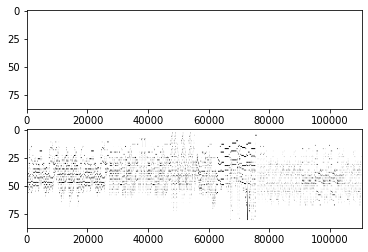

In [ ]:
#@title Plot result
'''###### TRAIN 1: DNN - 3 layers - 150 unis per layer ######'''


# We need to set the random seed so that we get ther same results with the same parameters
np.random.seed(400)  



mini_batch_size, num_epochs = 100, 50
input_size = 252
number_units = 256
number_layers = 3
number_classes = 88
data_directory = "/content/drive/MyDrive/Lil_Beethoven/Output/test/"
weights_dir = "/content/drive/MyDrive/Lil_Beethoven/Saved_weights/"

predictions_draw = []
y_draw = []
print ('Predict . . . ')
num_test_batches = len([name for name in os.listdir(data_directory)])/2
num_test_batches = int(num_test_batches)

y = []
print ('Loading test data')
for i in range(num_test_batches):
    print ("Batching..." + str(i) + "test_X.npy")
    y_test = np.array(np.load(data_directory + str(i) + "test_y.npy" ))
    if i == 0:
        y = y_test
    else:
        y = np.concatenate((y,y_test), axis = 0)


predictions = np.load(weights_dir + "predictions_post.npy" ) 
plt.figure()
plt.subplot(211)
plt.imshow(predictions.transpose(),cmap='Greys',aspect='auto')

plt.subplot(212)
plt.imshow(y.transpose(),cmap='Greys',aspect='auto')
plt.show()